In [24]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
from typing import List, Tuple

# All functions

In [33]:
def psnr(orig: np.ndarray, comp: np.ndarray) -> np.float32:
    """ This function calculates the PSNR of the original and the reconstructed image

    Args:
        orig (np.ndarray): Original image
        comp (np.ndarray): Constructed image

    Returns:
        np.float32: PSNR
    """
    mse = np.mean((orig - comp) ** 2)
    psnr = 20 * np.log10(255.0 / np.sqrt(mse))
    
    return psnr

def get_image_blocks(img: np.ndarray, size=4) -> np.ndarray:
    """Gets all the size x size blocks from the image in an array

    Args:
        img (np.ndarray): 
        size (int, optional): The size of the square block. Defaults to 4.

    Returns:
        np.ndarray: array of all the extracted blocks from the image 
    """
    h, w = img.shape

    # If the image is not even sized, then we will take only the
    # viable blocks
    h_fac, w_fac = h // size, w // size

    img_blocks = []
    for i in range(0, size*w_fac, size):
        for j in range(0, size*h_fac, size):
            img_blocks.append(img[i:i+size, j:j+size])

    img_blocks = np.array(img_blocks, dtype=object).reshape(-1, size, size)

    return img_blocks

def apply_dct(blocks: np.ndarray) -> List:
    """Applies DCT to each image block

    Args:
        blocks (np.ndarray): Image blocks

    Returns:
        List: Output list of DCT of image blocks
    """
    dct_blocks = []
    for block in blocks:
        dct_block = cv2.dct(np.float32(block))
        dct_blocks.append(dct_block)

    return dct_blocks

def reconstruct(img: np.ndarray, dct_blocks: List) -> Tuple:
    """DCT function to reconstruct the image with different values of 
    retained DCT coefficients and return the reconstructed images along with
    other values

    Args:
        img (np.ndarray): Input grayscale image for size and MSE calculation
        dct_blocks (List): List of DCT blocks of original image

    Returns:
        Tuple: Values of K, MSEs, PSNRs, reconstructed images, times
    """
    K = [2, 4, 8, 16, 32, 64]  # Number of coefficients to keep
    mse = []
    psnrs = []
    reconstructions = []
    times = []

    for k in K:
        start = time.time()
        new_blocks = []

        # Loop through each block
        for dct_block in dct_blocks:
            flat_dct_block = dct_block.flatten()

            # Find the indices of the 64-k smallest coefficients
            indices = np.argsort(np.abs(flat_dct_block))[::-1][k:]

            # Set the values in all those indices to 0
            flat_dct_block[indices] = 0

            # Take the inverse dct of the new block and append it to a list
            new_block = cv2.idct(flat_dct_block.reshape((8, 8)))
            new_blocks.append(new_block)

        reconstruction = np.zeros_like(img)
        idx = 0

        # Rearrange the blocks to form the reconstructed image
        for i in range(0, img.shape[0], 8):
            for j in range(0, img.shape[1], 8):
                reconstruction[i:i+8, j:j+8] = new_blocks[idx]
                idx += 1
        
        # Caluclate MSE, PSNR, and time and append it to lists
        mse.append(np.mean((img - reconstruction)**2))
        reconstructions.append(reconstruction)
        psnrs.append(psnr(img, reconstruction))
        end = time.time()
        times.append((end-start))

    return K, mse, psnrs, reconstructions, times


# DCT and Reconstruction

In [34]:
# Load the image
img = cv2.imread('./test_images/baboon.png', cv2.IMREAD_GRAYSCALE)
blocks = get_image_blocks(img, size=8)

# Apply DCT to each block
dct_blocks = apply_dct(blocks)
K, mse, psnrs, reconstructions, times = reconstruct(img, dct_blocks)

# Plotting

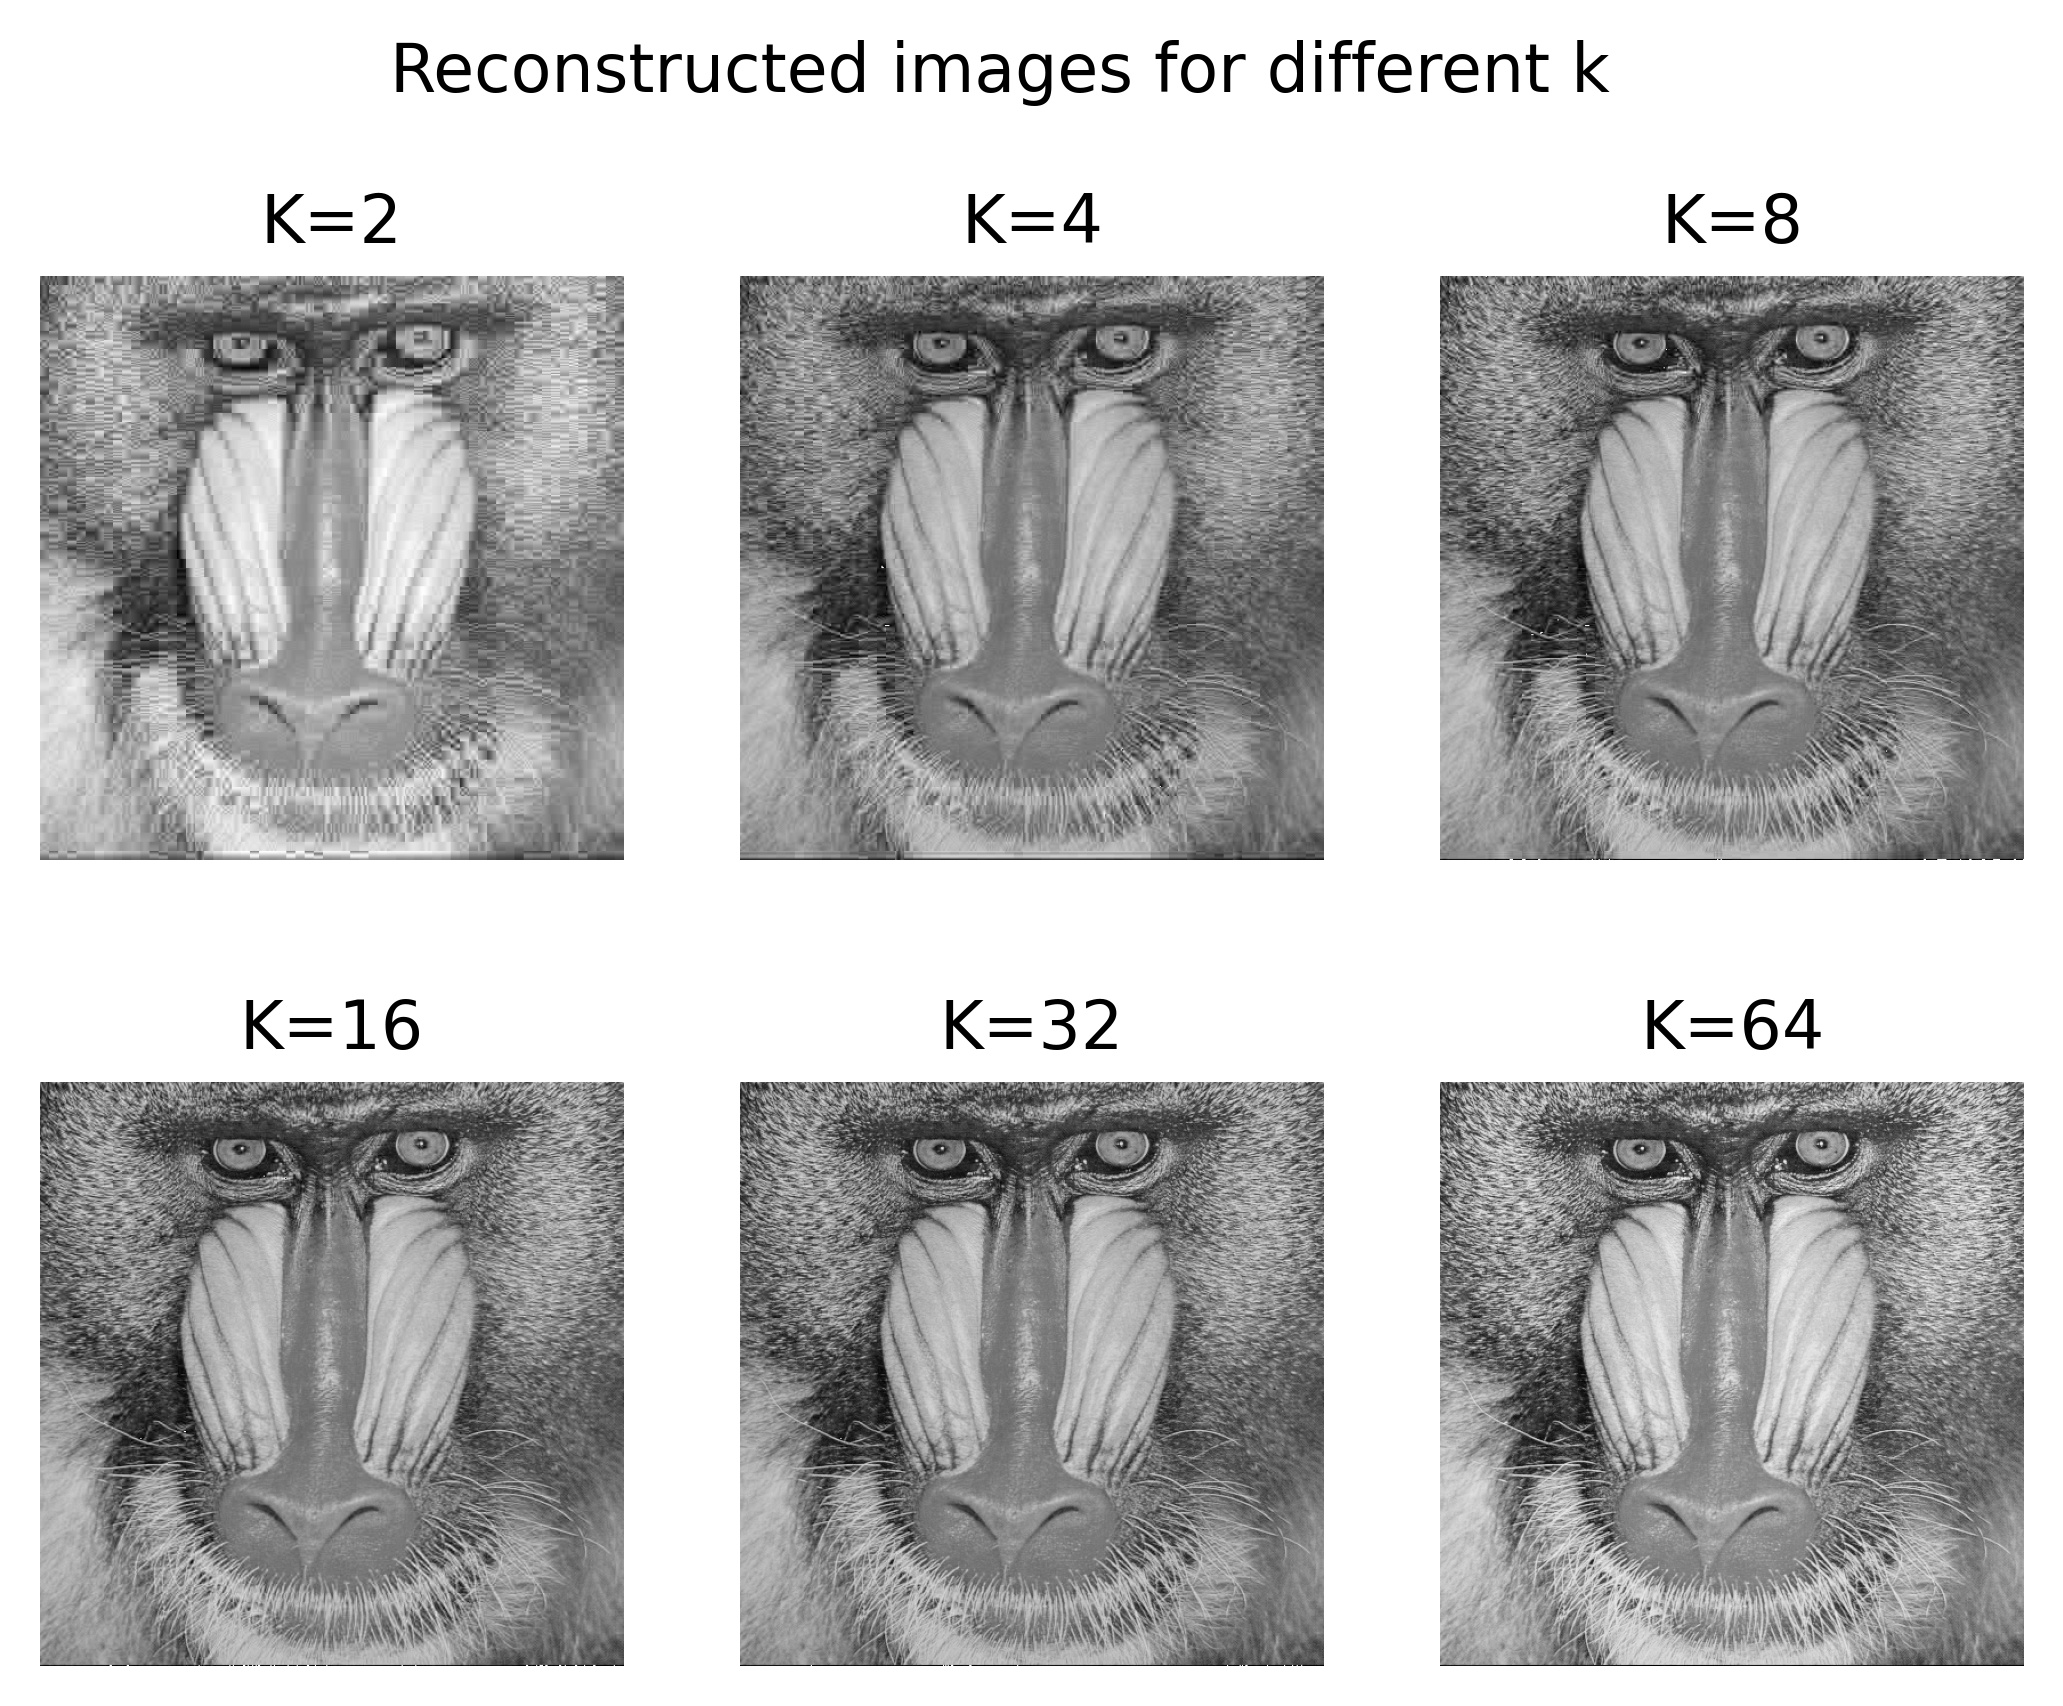

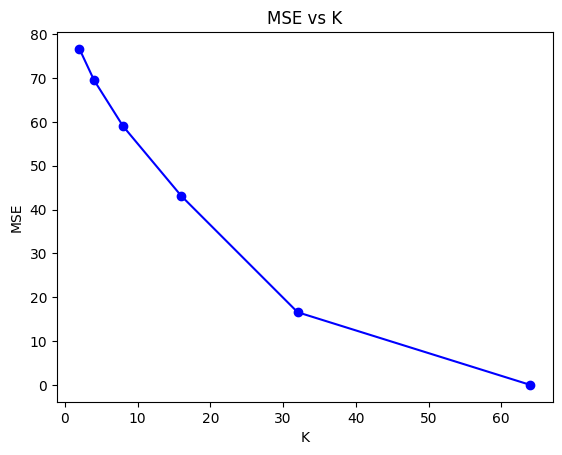

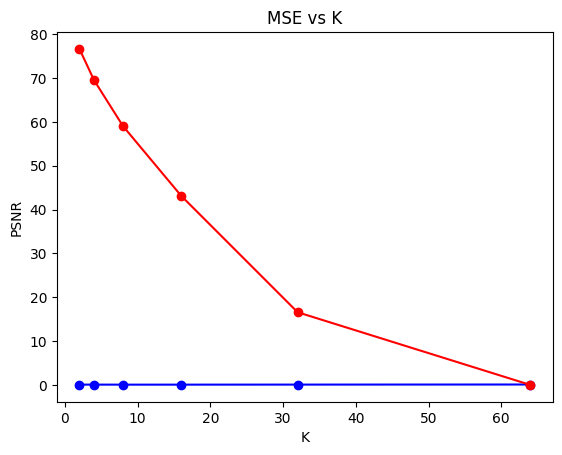

In [35]:
# Plot the reconstructed images for different values of K
fig, axs = plt.subplots(2, 3, dpi=400)
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.imshow(reconstructions[i], cmap='gray')
    ax.set_title(f'K={K[i]}')
    ax.axis('off')
plt.suptitle('Reconstructed images for different k')
plt.show()

# Plot the MSE for different values of K
plt.plot(K, mse, 'bo-')
plt.title('MSE vs K')
plt.xlabel('K')
plt.ylabel('MSE')
plt.show()

# Plot the PSNR for different values of K
plt.plot(K, times, 'bo-')
plt.plot(K, mse, 'ro-')
plt.title('MSE vs K')
plt.xlabel('K')
plt.ylabel('PSNR')
plt.show()
